
## Instruksi

Jalankan code berikut pada Google Colab dan PyDroid3 (Android Python Application) di Smartphone Android. Bandingkan hasilnya dan tuliskan analisa anda, tuliskan juga spesifikasi smartphone yang anda gunakan :).


In [ ]:
pip install annoy faiss-cpu hnswlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 26.1 MB/s eta 0:00:00
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551808 sha256=cafa8d06e71dbe587b33d62c7b916b5904867a5b1be9f3fc3ae8184962069da7
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
  Created wheel for hnswlib: filename=hnswlib-0.8.0-cp312-cp312-linux_x86_64.whl size=2528149 sha256=9163d7edc78da94361b9d5022977d1f529df1c95a47e40de2cd2be1bf0cd1202
  Stored in directory: /root/.cache/pip/wheels/ac/39/b3/cbd7f9cbb76501d2d5fbc84956e70d0b94e788aac87bda465e
Successfully built annoy hnswlib


In [ ]:
import numpy as np
import time
from sklearn.neighbors import NearestNeighbors
from annoy import AnnoyIndex
import hnswlib
import faiss
from sklearn.preprocessing import StandardScaler

# -------------------------------
# Contoh dataset kecil untuk testing
# -------------------------------
np.random.seed(42)
n_samples = 10000   # jumlah database vector
d = 128             # dimensi
X = np.random.random((n_samples, d)).astype('float32')

# Standarisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 10  # jumlah nearest neighbors

# -------------------------------
# Exact NN (brute-force)
# -------------------------------
start = time.time()
nn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')
nn.fit(X_scaled)
dist_exact, idx_exact = nn.kneighbors(X_scaled)
time_exact = time.time() - start
print(f"Exact NN done in {time_exact:.3f} s")

# -------------------------------
# Annoy
# -------------------------------
start = time.time()
f = X_scaled.shape[1]
index_annoy = AnnoyIndex(f, 'euclidean')
for i, v in enumerate(X_scaled):
    index_annoy.add_item(i, v)
index_annoy.build(10)
idx_annoy = [index_annoy.get_nns_by_vector(v, k) for v in X_scaled]
time_annoy = time.time() - start
print(f"Annoy done in {time_annoy:.3f} s")

# -------------------------------
# HNSW
# -------------------------------
start = time.time()
p_hnsw = hnswlib.Index(space='l2', dim=d)
p_hnsw.init_index(max_elements=n_samples, ef_construction=200, M=16)
p_hnsw.add_items(X_scaled)
p_hnsw.set_ef(200)
idx_hnsw, _ = p_hnsw.knn_query(X_scaled, k=k)
time_hnsw = time.time() - start
print(f"HNSW done in {time_hnsw:.3f} s")

# -------------------------------
# FAISS IVF
# -------------------------------
start = time.time()
quantizer = faiss.IndexFlatL2(X_scaled.shape[1])
index_faiss = faiss.IndexIVFFlat(quantizer, X_scaled.shape[1], 100)  # nlist=100 sebagai argumen posisi
index_faiss.train(X_scaled.astype('float32'))
index_faiss.add(X_scaled.astype('float32'))
index_faiss.nprobe = 10
dist_faiss, idx_faiss = index_faiss.search(X_scaled.astype('float32'), k)
time_faiss = time.time() - start
print(f"FAISS IVF done in {time_faiss:.3f} s")

# -------------------------------
# Tampilkan ringkasan waktu
# -------------------------------
print("\n=== Ringkasan Waktu (detik) ===")
print(f"Exact NN : {time_exact:.3f}")
print(f"Annoy    : {time_annoy:.3f}")
print(f"HNSW     : {time_hnsw:.3f}")
print(f"FAISS    : {time_faiss:.3f}")

Exact NN done in 2.626 s
Annoy done in 1.222 s
HNSW done in 14.825 s
FAISS IVF done in 1.591 s

=== Ringkasan Waktu (detik) ===
Exact NN : 2.626
Annoy    : 1.222
HNSW     : 14.825
FAISS    : 1.591


## Spesifikasi Handphone

    Chipset: MediaTek Helio G99 (6nm) <br>
    CPU: Octa-core (2x2.2 GHz Cortex-A76 & 6x2.0 GHz Cortex-A55) <br>
    GPU: Mali-G57 MC2 <br>
    RAM: 8 GB (bisa diperluas hingga 16 GB dengan Extended RAM)<br>
    Penyimpanan Internal: 256 G<br

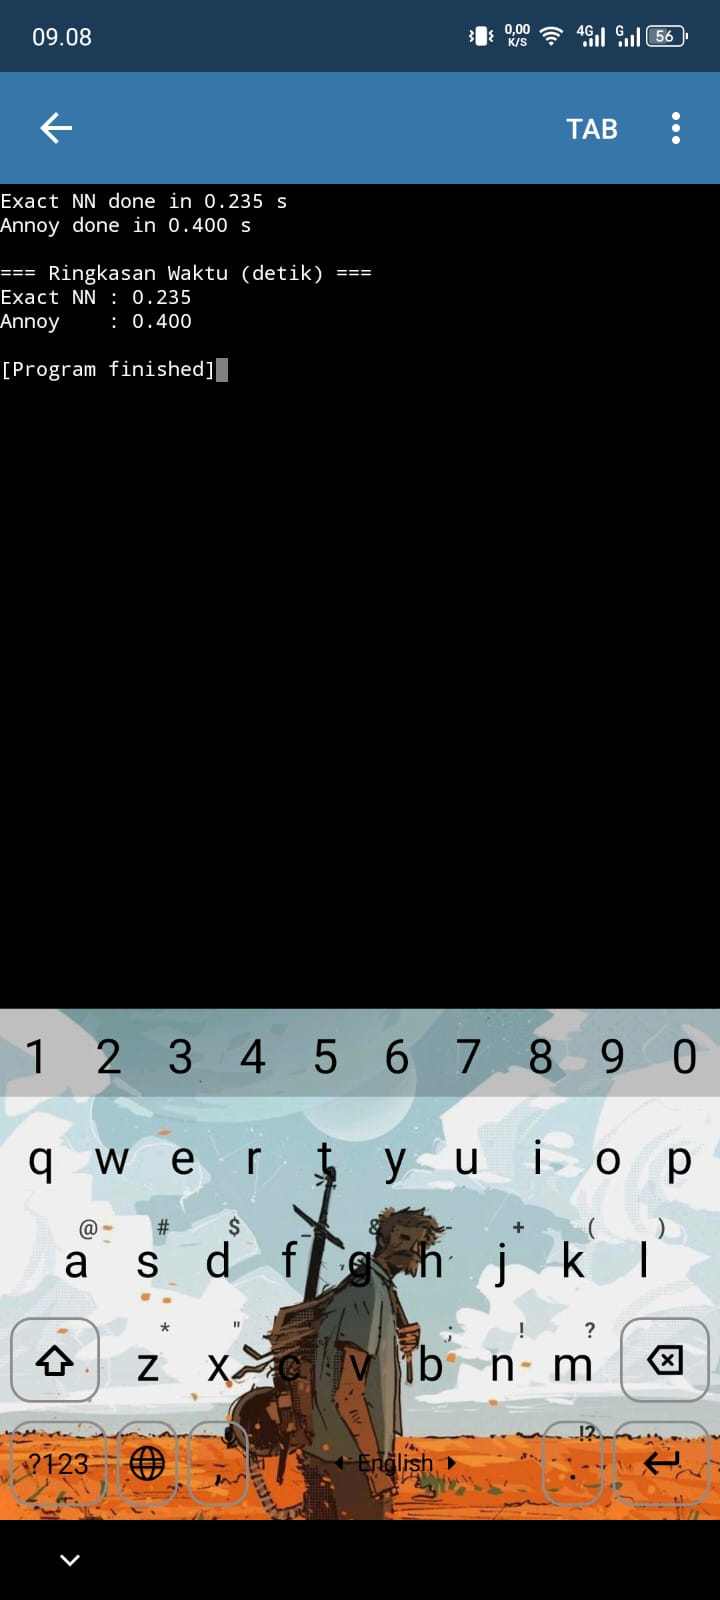